<a href="https://colab.research.google.com/github/laurabishop/MusicDiscoveryPupil/blob/main/MusicDiscoveryPhysiology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysing Physiological Data Collected during Music Listening: Pupillometry


The eye's pupil dilates in response to increases in mental effort (i.e., the amount of attention and cognitive arousal that is evoked by a task). Under carefully controlled visual conditions, pupil diameter can be used as a psychophysiological index of attention. Pupil size can be captured using eye-tracking technology. Modern eye-trackers use cameras to measure the position and size of the pupil at a high frame rate.

In this part of the tutorial, we are going to explore eye-tracking data that were captured during a music discovery task.

## 0. Loading packages

In [95]:
shell_call <- function(command, ...) {
  result <- system(command, intern = TRUE, ...)
  cat(paste0(result, collapse = "\n"))
}

In [ ]:
shell_call("sudo apt update -qq && apt install --yes --no-install-recommends wget ca-certificates gnupg")
shell_call("wget -q -O- https://eddelbuettel.github.io/r2u/assets/dirk_eddelbuettel_key.asc | tee -a /etc/apt/trusted.gpg.d/cranapt_key.asc")

In [97]:
shell_call('echo "deb [arch=amd64] https://r2u.stat.illinois.edu/ubuntu jammy main" > /etc/apt/sources.list.d/cranapt.list')
shell_call('sudo apt update -qq')

149 packages can be upgraded. Run 'apt list --upgradable' to see them.

In [98]:
shell_call('echo "Package: *" > /etc/apt/preferences.d/99cranapt')
shell_call('echo "Pin: release o=CRAN-Apt Project" >> /etc/apt/preferences.d/99cranapt')
shell_call('echo "Pin: release l=CRAN-Apt Packages" >> /etc/apt/preferences.d/99cranapt')
shell_call('echo "Pin-Priority: 700"  >> /etc/apt/preferences.d/99cranapt')

In [ ]:
shell_call('sudo apt install r-cran-lme4')
shell_call('sudo apt install r-cran-ggplot2')
shell_call('sudo apt install r-cran-mgsub')
shell_call('sudo apt install r-cran-sciplot')
shell_call('sudo apt install r-cran-car')

In [100]:
install.packages(c("FBN", "lmerTest"), lib = "/usr/local/lib/R/site-library")

In [ ]:
lapply(c("ggplot2", "FBN", "mgsub", "sciplot", "lme4", "lmerTest", "car"), require, character.only = TRUE)

## 1. Description of the data

We have created two files that contain subsets of the full dataset ("full-dataset.json") for use in this part of the tutorial.


*   **ET-partial1.txt** includes participant ID, session numbers, Spotify ID for each music track, track time (where 0 = start of the track), filtered pupil diameter, filtered and normalized pupil diameter, RSME ratings, liking ratings, and track familiarity.
*   **ET-partial2.txt** includes participant ID, session numbers, Spotify ID for each music track, track time (where 0 = start of the track), filtered pupil diameter, filtered and normalized pupil diameter, binocular gaze X and Y position data, and subjective emotion data (AOI hits in the Circumplex model).

We will use **ET-partial1.txt** to test the relationship between pupil size and RSME, liking, and familiarity, and **ET-partial2.txt** to test the relationship between pupil size and emotional response.

These files can be loaded into R using the read.table function. They will appear as data frames with variables listed in columns. Each row corresponds to a single observation of data for one participant/session/track.



In [102]:
shell_call("git clone https://github.com/laurabishop/MusicDiscoveryPupil")

Warning message in system(command, intern = TRUE, ...):
“running command 'git clone https://github.com/laurabishop/MusicDiscoveryPupil' had status 128”


In [103]:
partial1 <- read.table("MusicDiscoveryPupil/ET-partial1.txt")
head(partial1)

,ID,session,spotify_id,tracktime,smooth.pupil,npupil,RSME,liking,track_familiarity
,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
6825,2067560969,1,0zmcNcsVTtzmKjTCYmUgER,0.00000000,NA,NA,100,5,4
6826,2067560969,1,0zmcNcsVTtzmKjTCYmUgER,0.01600003,NA,NA,100,5,4
6827,2067560969,1,0zmcNcsVTtzmKjTCYmUgER,0.03299999,NA,NA,100,5,4
6828,2067560969,1,0zmcNcsVTtzmKjTCYmUgER,0.04999995,NA,NA,100,5,4
6829,2067560969,1,0zmcNcsVTtzmKjTCYmUgER,0.06599998,NA,NA,100,5,4
6830,2067560969,1,0zmcNcsVTtzmKjTCYmUgER,0.08299994,NA,NA,100,5,4


In [104]:
partial2 <- read.table("MusicDiscoveryPupil/ET-partial2.txt")
head(partial2)

,ID,session,spotify_id,tracktime,smooth.pupil,npupil,Gaze.point.X,Gaze.point.Y,AOI.hit..Activation.,AOI.hit..Pleasant.,⋯,AOI.hit..Relaxed.,AOI.hit..Calm.,AOI.hit..Fatigued.,AOI.hit..Lethargic.,AOI.hit..Depressed.,AOI.hit..Sad.,AOI.hit..Upset.,AOI.hit..Stressed.,AOI.hit..Nervous.,AOI.hit..Tense.
,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
6825,2067560969,1,0zmcNcsVTtzmKjTCYmUgER,0.00000000,NA,NA,0.6714,0.4251,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6826,2067560969,1,0zmcNcsVTtzmKjTCYmUgER,0.01600003,NA,NA,0.5634,0.4249,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6827,2067560969,1,0zmcNcsVTtzmKjTCYmUgER,0.03299999,NA,NA,0.5409,0.4236,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6828,2067560969,1,0zmcNcsVTtzmKjTCYmUgER,0.04999995,NA,NA,0.5279,0.4246,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6829,2067560969,1,0zmcNcsVTtzmKjTCYmUgER,0.06599998,NA,NA,0.5206,0.4246,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6830,2067560969,1,0zmcNcsVTtzmKjTCYmUgER,0.08299994,NA,NA,0.5212,0.4238,0,0,⋯,0,0,0,0,0,0,0,0,0,0


Two other data files are associated with Section 2: "Pre-processing of pupil data".

*   **PLR.txt** contains a timestamp and pupil diameters for left and right eyes. This file contains data from a pupil light response task where a participant sat in darkness, and was periodically briefly presented with a bright light. The data can be plotted to show how the pupil responds to changes in lighting, but in this tutorial, we use it to illustrate examples of blinks.
*   **2067560969.txt** contains data from one participant, including participant ID, timestamp and track time, session number, gaze positions, ratings (liking, familiarity, RSME, fatigue, etc.). We use data from one trial for this participant to illustrate the pupil filtering procedure.



In [105]:
plr <- read.table("MusicDiscoveryPupil/PLR.txt", skip = 32, header = T, sep = ";")
head(plr)

,Time,Type,Trial,L.Pupil.Diameter..mm.,R.Pupil.Diameter..mm.
,<int>,<chr>,<int>,<dbl>,<dbl>
1,188886778,SMP,1,4.38,4.22
2,188903388,SMP,1,4.34,4.22
3,188919955,SMP,1,4.34,4.24
4,188936502,SMP,1,4.34,4.30
5,188953010,SMP,1,4.34,4.28
6,188969814,SMP,1,4.36,4.32


In [106]:
P2067560969 <- read.table("MusicDiscoveryPupil/P2067560969.txt")
head(P2067560969)

,timestamp,session,Gaze.point.X,Gaze.point.Y,Gaze.point.left.X,Gaze.point.left.Y,Gaze.point.right.X,Gaze.point.right.Y,Fixation.point.X,Fixation.point.Y,⋯,liking,genre_familiarity,artist_familiarity,track_familiarity,RSME,relaxed,motivation,fatigue,ID,tracktime
,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
6825,1682511487,1,0.6714,0.4251,0.6697,0.4356,0.6732,0.4147,0.6819,0.4354,⋯,5,4,4,4,100,5,7,1,2067560969,0.00000000
6826,1682511487,1,0.5634,0.4249,0.5638,0.4397,0.5630,0.4100,NA,NA,⋯,5,4,4,4,100,5,7,1,2067560969,0.01600003
6827,1682511487,1,0.5409,0.4236,0.5426,0.4360,0.5392,0.4113,NA,NA,⋯,5,4,4,4,100,5,7,1,2067560969,0.03299999
6828,1682511487,1,0.5279,0.4246,0.5272,0.4316,0.5287,0.4176,0.5235,0.4224,⋯,5,4,4,4,100,5,7,1,2067560969,0.04999995
6829,1682511487,1,0.5206,0.4246,0.5149,0.4267,0.5262,0.4225,0.5235,0.4224,⋯,5,4,4,4,100,5,7,1,2067560969,0.06599998
6830,1682511487,1,0.5212,0.4238,0.5158,0.4251,0.5265,0.4224,0.5235,0.4224,⋯,5,4,4,4,100,5,7,1,2067560969,0.08299994


## 2. Pre-processing of pupil data
### 2.1 Blinks
Pupil data normally contain blinks and other artifacts that should be removed before the data are used for any analysis. Below is an example of data containing blinks. A few samples are captured while the pupil is fully covered by the eyelid, resulting in a pupil size of 0 mm. A few samples are also captured while the eye is only partially covered by the eyelid. This results in a pupil size that is greater than 0, but much smaller than the average size for the trial. When pupil data are filtered, both complete and partial blinks need to be accounted for.

In [107]:
blink <- read.table("MusicDiscoveryPupil/PLR.txt", skip = 32, header = T, sep = ";")
blink$trialtime <- with(blink, (Time-Time[1])*(10^-6))

Warning message:
“Removed 3262 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 3262 rows containing missing values (`geom_point()`).”


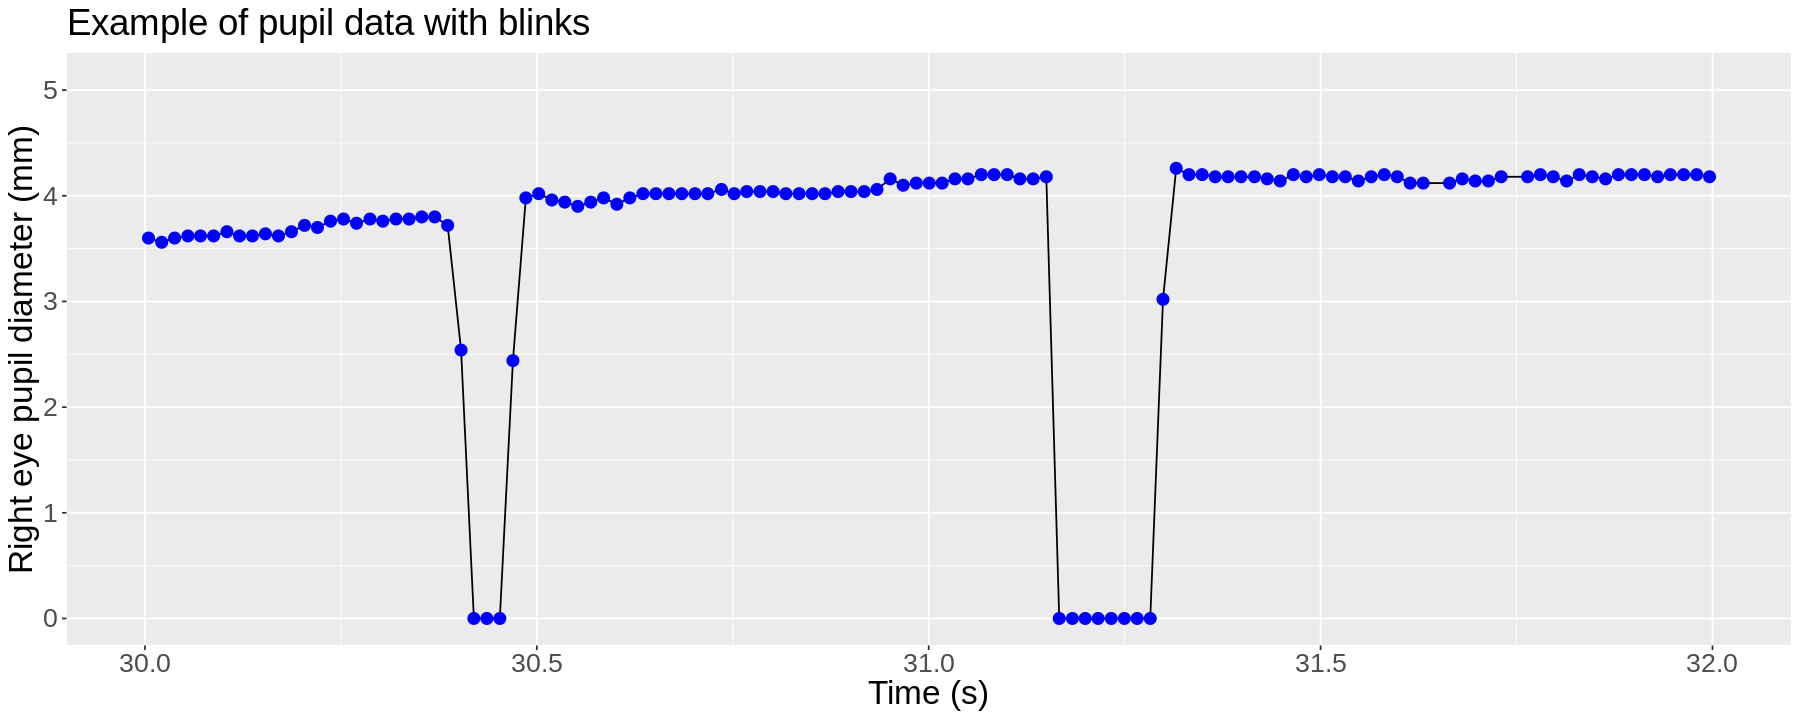

In [113]:
options(repr.plot.width = 15, repr.plot.height = 6)
ggplot(blink,
aes(x = trialtime, y = R.Pupil.Diameter..mm.)) + geom_line() + #geom_point(size = 3, colour = "blue") + xlim(30, 32) +
  xlab("Time (s)") + ylab("Right eye pupil diameter (mm)") +
  ggtitle("Example of pupil data with blinks") +
  theme(plot.title = element_text(size = 22), axis.text = element_text(size = 16), axis.title = element_text(size = 20))

### 2.2 Filtering pupil data
Some eye-tracking software includes a function for distinguishing fixations, saccades, and blinks:


*   **Fixations** occur when gaze is maintained on a single location
*   **Saccades** occur when gaze rapidly moves between locations
*   **Blinks** occur when the eye is fully or partially covered by the eyelid


Using such a function, you can get "clean" data for analysis by extracting only the fixations -- noting that fixations will not be evenly spaced in time. Fixation data is best for very detailed analysis of pupil dilations, because saccades (and blinks, of course) add noise to pupil data. If a blink detection function is not available or reliable, it may be necessary to work with raw data and filter out blinks and artifacts during pre-processing.

**Visualizing pupil data with blinks.** Below is an example of data from the Music Discovery dataset. Blinks are coded as NA in these data, so they appear as brief gaps. The "edges" of blinks appear as instantaneous drops in pupil size. There is also a longer period of missing data towards the end of the trial (probably because the participant looked away from the eye-tracker).

**Differences in size between left and right pupils.** Note that the left and right pupils follow similar trajectories, but are not identical in diameter. There is commonly a small difference between eyes in recorded pupil size, which is partially attributable to physiological differences between the eyes, and also sometimes partially attributable to measurement error (especially if the participant looks at more extreme angles or moves their head). Typically, pupillometry studies either use data from one eye or average data across both eyes.

In [114]:
eyetracking <- read.table("MusicDiscoveryPupil/P2067560969.txt")

In [115]:
session.no <- 1
track <- "3c879SgICdtgNLUdzHHs8F"
tdata <- eyetracking[eyetracking$session == session.no & eyetracking$spotify_id == track, ]

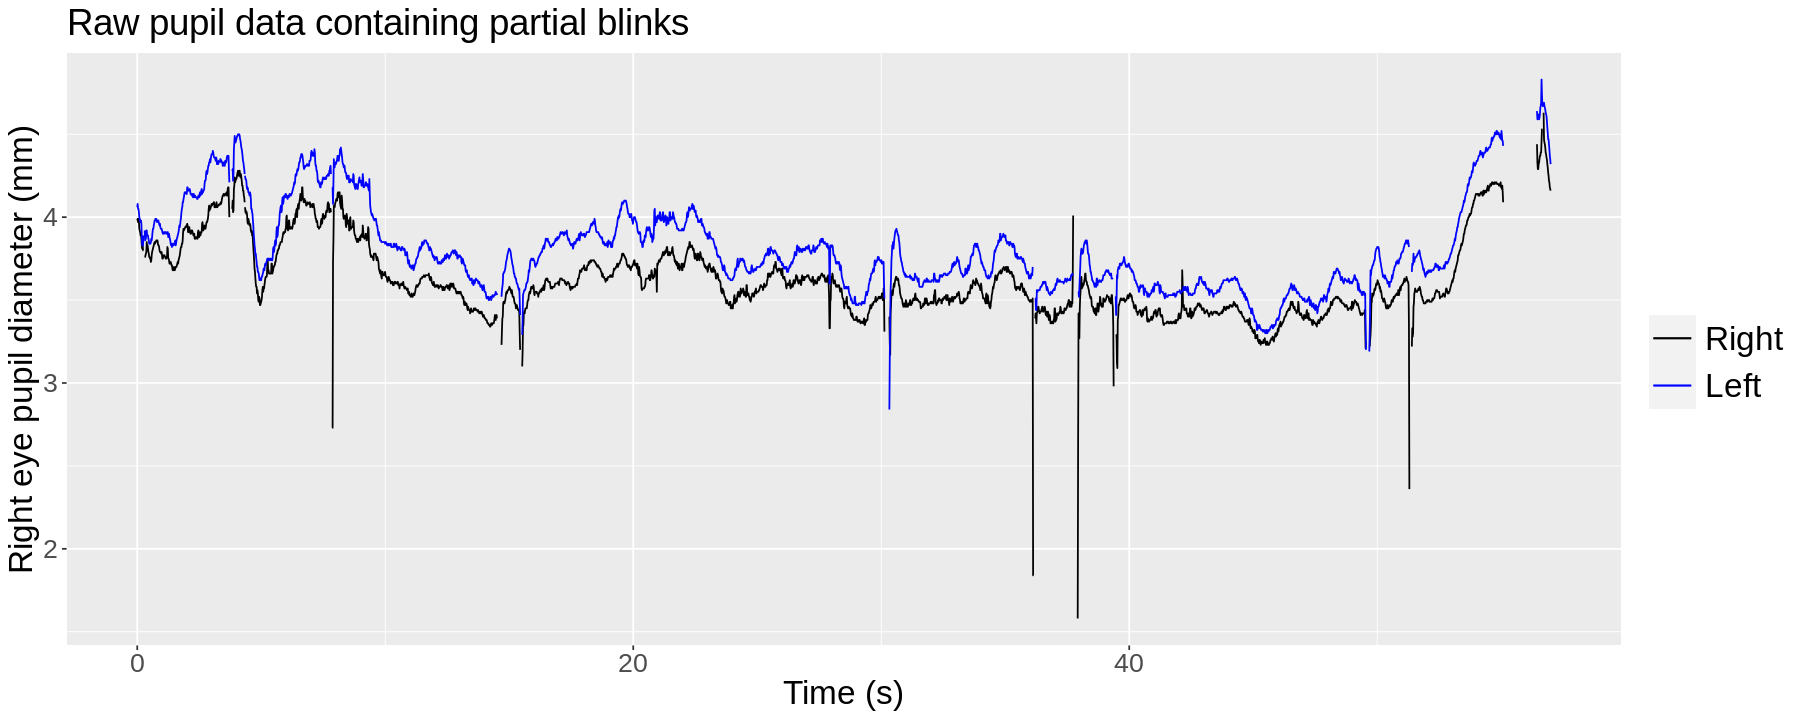

In [124]:
raw.plot <- ggplot(tdata, aes(x = tracktime)) + #xlim(30,40) +
                geom_line(aes(y = Pupil.diameter.right..mm., colour = "Right")) +
                geom_line(aes(y = Pupil.diameter.left..mm., colour = "Left")) +
                scale_colour_manual("", breaks = c("Right", "Left", "Smoothed", "Interpolated"),
                                    values = c("black", "blue", "red", "orange")) +
                ggtitle("Raw pupil data containing partial blinks") +
                xlab("Time (s)") + ylab("Right eye pupil diameter (mm)") +
                theme(plot.title = element_text(size = 22),
                      axis.text = element_text(size = 16), axis.title = element_text(size = 20),
                      legend.text = element_text(size = 20), legend.key.size = unit(1, "cm"))
raw.plot

We run a filter on these data that includes several steps. This is a customizable filter that is intended to work with data collected under different conditions using different eye-tracking devices. Depending on the quality of the data and the aim of the analyses, some steps might be skipped (e.g., smoothing). It might also be necessary to change some of the parameters. In this demo, we run steps 2-6, and the filter outputs a single continuous (i.e., without gaps) vector of smoothed pupil data.

* **Step 1**: *We skip this step here because the data do not contain values of 0.* Some data contain pupil sizes of 0, which arise during complete blinks or in moments where the pupil cannot be detected--for example, because the participant looks away from the eyetracker. Some software might code these values as NA (missing data) instead of 0. If values of 0 are present in the data, the first step would be to exclude them and replace them with NAs.
* **Step 1**: Filter out extreme velocities for each pupil individually. This targets the "edges" of blinks and other sudden changes in pupil size that arise because of mis-tracking.
* **Step 2**: Average left and right pupils.
* **Step 3**: Filter out extreme low values. Mostly these are samples from partial blinks that have excaped the velocity filter.
* **Step 4**: Run a linear interpolation to fill gaps. You can use other types of interpolations here. For example, a spline interpolation might be prefered in some cases (depending on how the data look, what size of gaps you need to fill, and what your eventual analysis will be). Here, we have some large gaps in some trials and prefer to maintain the average (tonic) pupil size in those cases.
* **Step 5**: Run a median filter to smooth the data.


In [118]:
outlier.value <- 3 # Used for defining outlier velocities in pupil filtering
low.threshold <- 2 # Used for cutting off values that are too far below trial mean
window.size <- 17 # Used to set the smoothing window

In [119]:
# Filter out extreme velocities for left pupil
tdata$xmm_velLeft <- with(tdata, c(NA, diff(Pupil.diameter.left..mm.))/c(NA, diff(timestamp)))
out.boundLeft <- outlier.value * sd(tdata$xmm_velLeft, na.rm = T)
tdata$xmm_ppLeft <- with(tdata, ifelse(abs(xmm_velLeft) > out.boundLeft, NA, Pupil.diameter.left..mm.))

# Filter out extreme velocities for right pupil
tdata$xmm_velRight <- with(tdata, c(NA, diff(Pupil.diameter.right..mm.))/c(NA, diff(timestamp)))
out.boundRight <- outlier.value * sd(tdata$xmm_velRight, na.rm = T)
tdata$xmm_ppRight <- with(tdata, ifelse(abs(xmm_velRight) > out.boundRight, NA, Pupil.diameter.right..mm.))

# Average filtered left and right pupils, then filter out extreme low values
tdata$pupil_lr <- with(tdata, (xmm_ppLeft + xmm_ppRight)/2)
low.bound <- mean(tdata$pupil_lr, na.rm = T) - low.threshold * sd(tdata$pupil_lr, na.rm = T)
tdata$xmm_ppp <- with(tdata, ifelse(pupil_lr < low.bound, NA, pupil_lr))

# Interpolate to fill gaps
tdata$pupil <- with(tdata, approx(timestamp, xmm_ppp, xout = timestamp)$y)

# Smoothing
tdata$smooth.pupil <- medianFilter(tdata$pupil, windowSize = window.size)

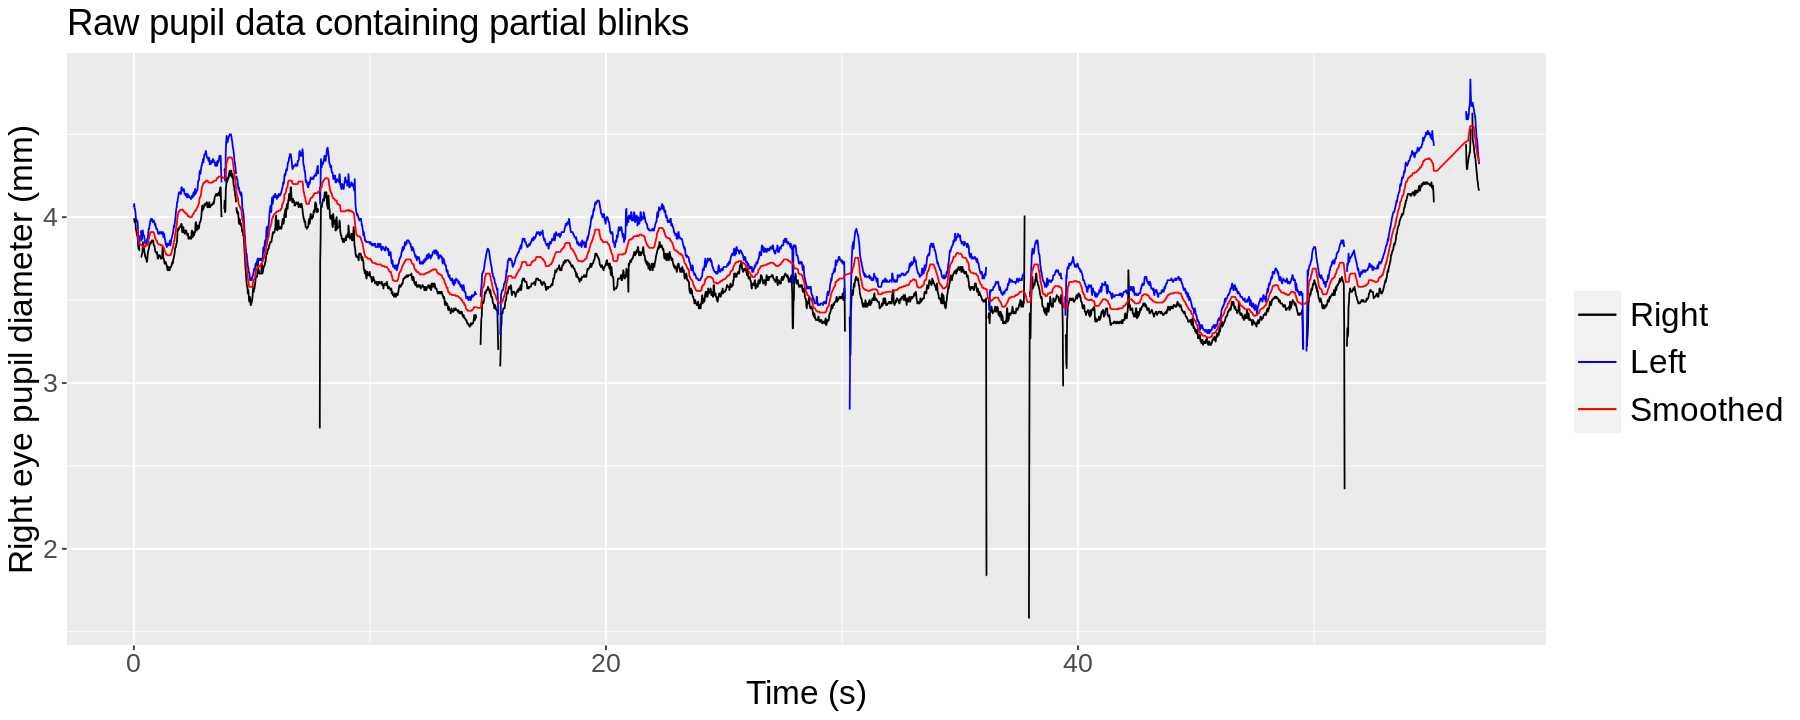

In [125]:
raw.plot <- raw.plot + geom_line(data = tdata, aes(y = smooth.pupil, colour = "Smoothed"))
#raw.plot <- raw.plot + geom_line(data = tdata, aes(y = pupil, colour = "Interpolated")) + xlim(0, 10)
suppressWarnings(print(raw.plot))

**Note on blink analysis.** Like pupil size, eye-blinks are a useful measure of mental effort. People tend to blink at a lower rate when cognitive load is high, but blink at a faster rate when arousal is high. Increased visual demands decrease blink rate, while fatigue increases blink rate.



## 3. Analysis of pupil data

In this part of the tutorial, we address three questions:

*   How does pupil size relate to self-reported mental effort (RSME scale)?
*   How does pupil size relate to liking and familiarity?
*   Does pupil size predict listeners' emotional response?



### 3.1 How does pupil size relate to self-reported mental effort (RSME scale)?

During the experiment, pupil data were collected as participants listened to several music tracks. They also had a "baseline" listening condition where they heard only a metronome. We would expect that pupil size is larger during the more stimulating music conditions than during the metronome condition. We would also expect that pupil size is more variable in the music conditions than in the metronome conditions as the demands on mental effort are constantly changing when music is playing. These differences are confirmed below with bargraphs showing differences in average pupil size and pupil size variability in the music and metronome conditions.

As a first step, before plotting the data, we will remove the last 5 seconds from all trials: we do this because participants were asked to make an active response (pressing a button to end the trial) when they had decided how much they liked the music. This active response had a noticable effect on pupil size (as well as EDA, as we see in the other part of the tutorial) that could affect the mean and variability values that we extract from the data.

In [126]:
filtered <- read.table("MusicDiscoveryPupil/ET-partial1.txt")

In [127]:
allshort <- data.frame(matrix(rep(NA, 9), nrow = 1))
for (i in unique(filtered$ID)) {
  for (s in unique(filtered[filtered$ID == i, c("session")])) {
    for (j in unique(filtered[filtered$ID == i & filtered$session == s, c("spotify_id")])) {
      trial <- filtered[filtered$ID == i & filtered$session == s & filtered$spotify_id == j, ]
      end.time <- max(trial$tracktime)
      short.trial <- trial[trial$tracktime < end.time-5, ]
      colnames(allshort) <- colnames(short.trial)
      allshort <- rbind(allshort, short.trial)
    }
  }
}
allshort <- allshort[-1, ]

In [128]:
nrow(allshort)
nrow(filtered)

[1] 509079

[1] 547840

In [129]:
allshort$trialtype <- with(allshort, ifelse(spotify_id == "metronome", "metronome", "song"))

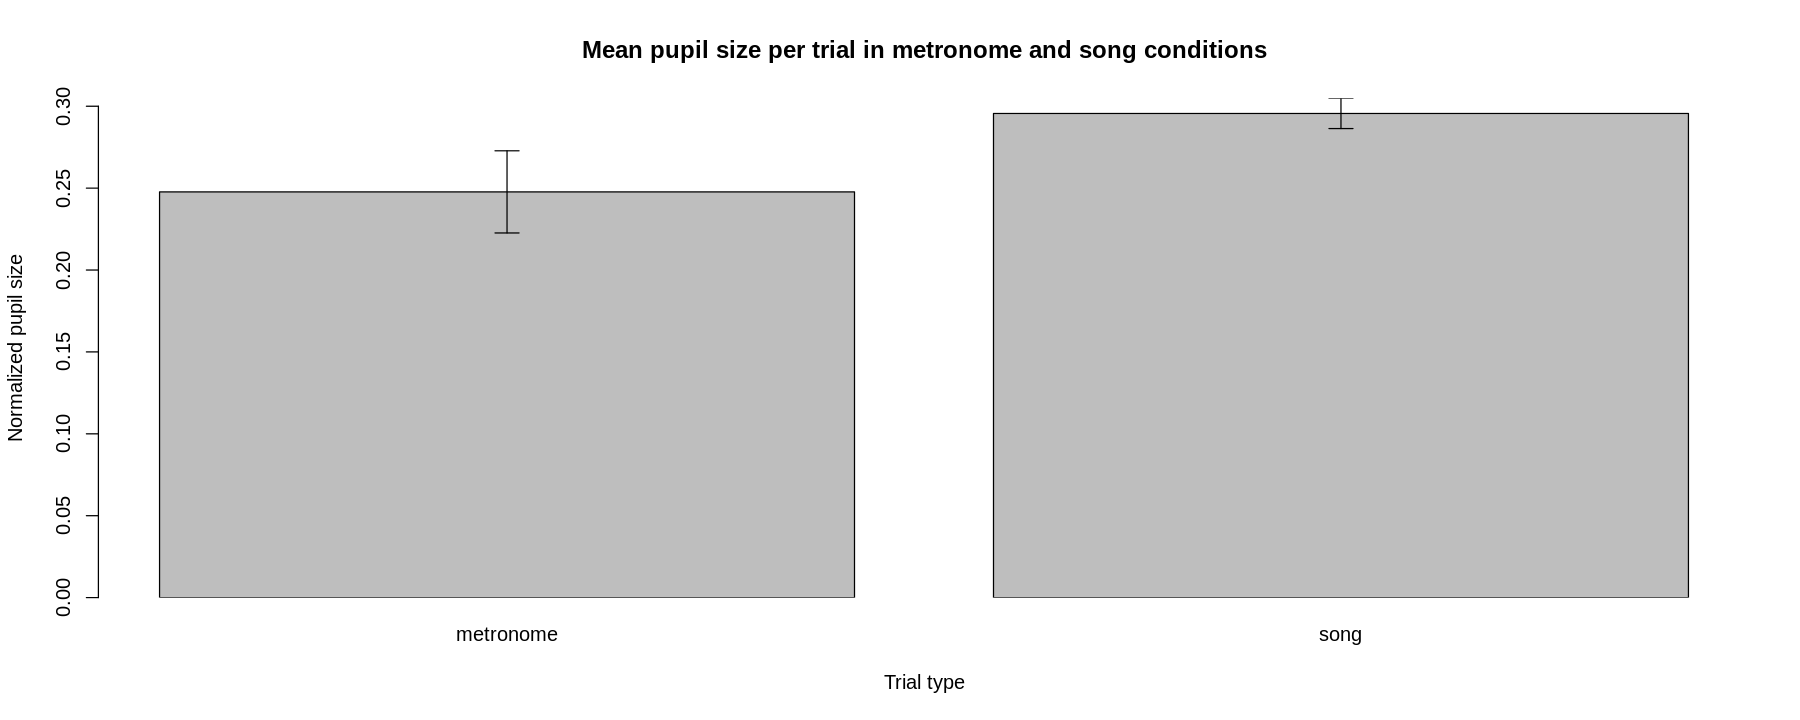

In [130]:
allshort.m <- aggregate(npupil ~ trialtype + ID + session + spotify_id, allshort, mean)
bargraph.CI(trialtype, npupil, data = allshort.m,
             main = "Mean pupil size per trial in metronome and song conditions",
             xlab = "Trial type", ylab = "Normalized pupil size")

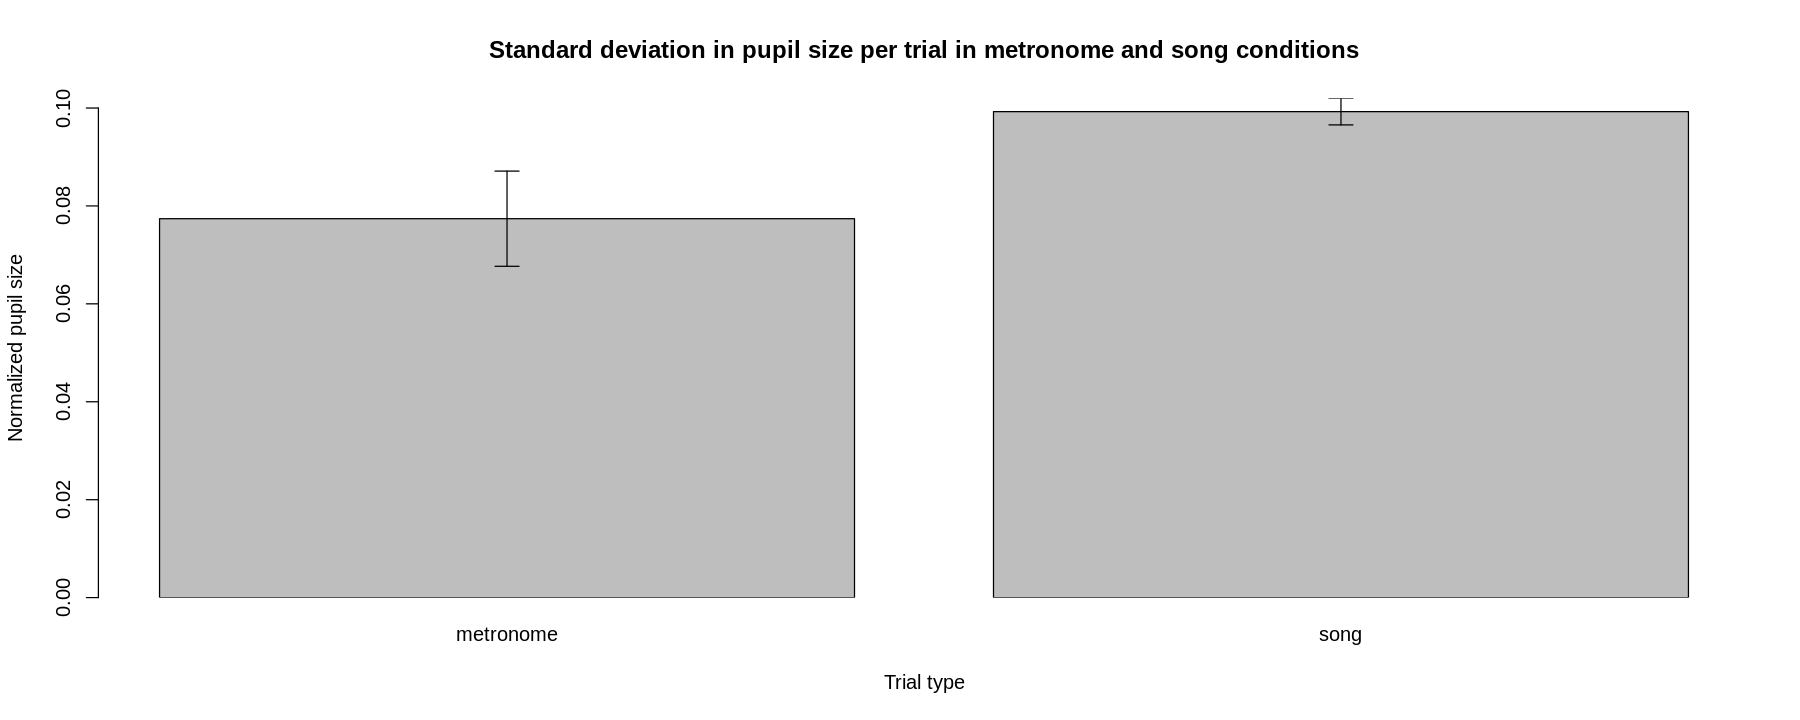

In [131]:
allshort.sd <- aggregate(npupil ~ trialtype + ID + session + spotify_id, allshort, sd)
bargraph.CI(trialtype, npupil, data = allshort.sd,
             main = "Standard deviation in pupil size per trial in metronome and song conditions",
             xlab = "Trial type", ylab = "Normalized pupil size")

The plots show that, as expected, mental effort was greater and more variable when participants heard music rather than a metronome.

During the experiment, participants rated their mental effort on the RSME at the end of each trial. Theoretically, subjective (RSME) and objective (pupil size) measures of mental effort should be positively related. We can test whether this is the case for our data, using a Spearman correlation.

In [ ]:
pupilxRSME <- aggregate(smooth.pupil ~ RSME + ID + spotify_id + session, data = allshort, mean)
pupilxRSME$ID <- factor(pupilxRSME$ID)

`geom_smooth()` using formula = 'y ~ x'


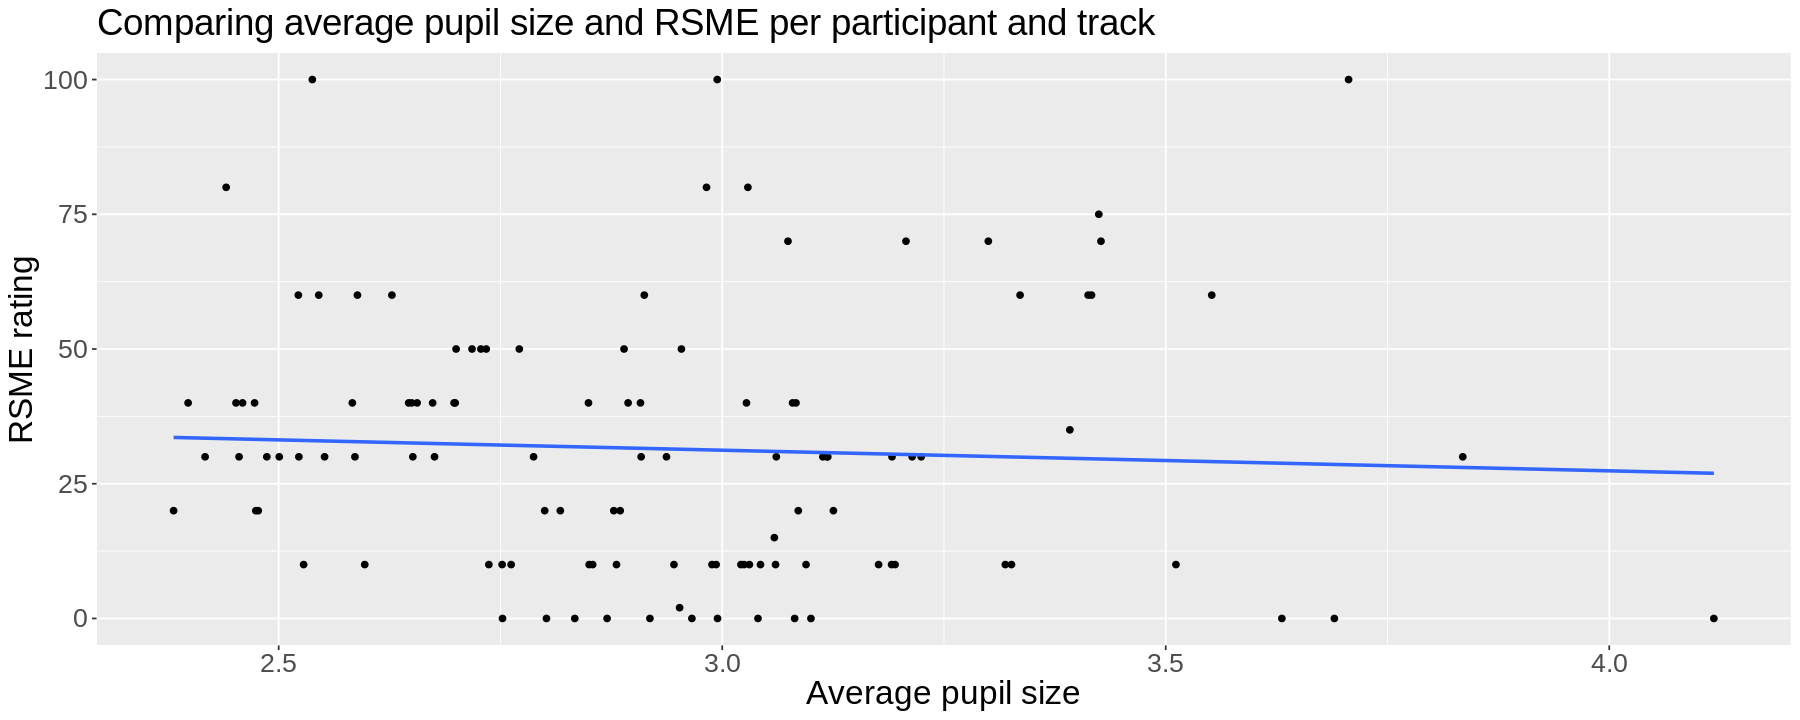

In [132]:
options(repr.plot.width = 15, repr.plot.height = 6)
effort.noID <- ggplot(pupilxRSME, aes(x = smooth.pupil, y = RSME)) + geom_point()
effort.noID <- effort.noID + ggtitle("Comparing average pupil size and RSME per participant and track") +
                                    xlab("Average pupil size") + ylab("RSME rating") +
                                    theme(plot.title = element_text(size = 22),
                                        axis.text = element_text(size = 16), axis.title = element_text(size = 20),
                                        legend.text = element_text(size = 20), legend.key.size = unit(1, "cm"),
                                        legend.title = element_text(size = 20))
effort.noID + geom_smooth(method = lm, se = FALSE)

`geom_smooth()` using formula = 'y ~ x'


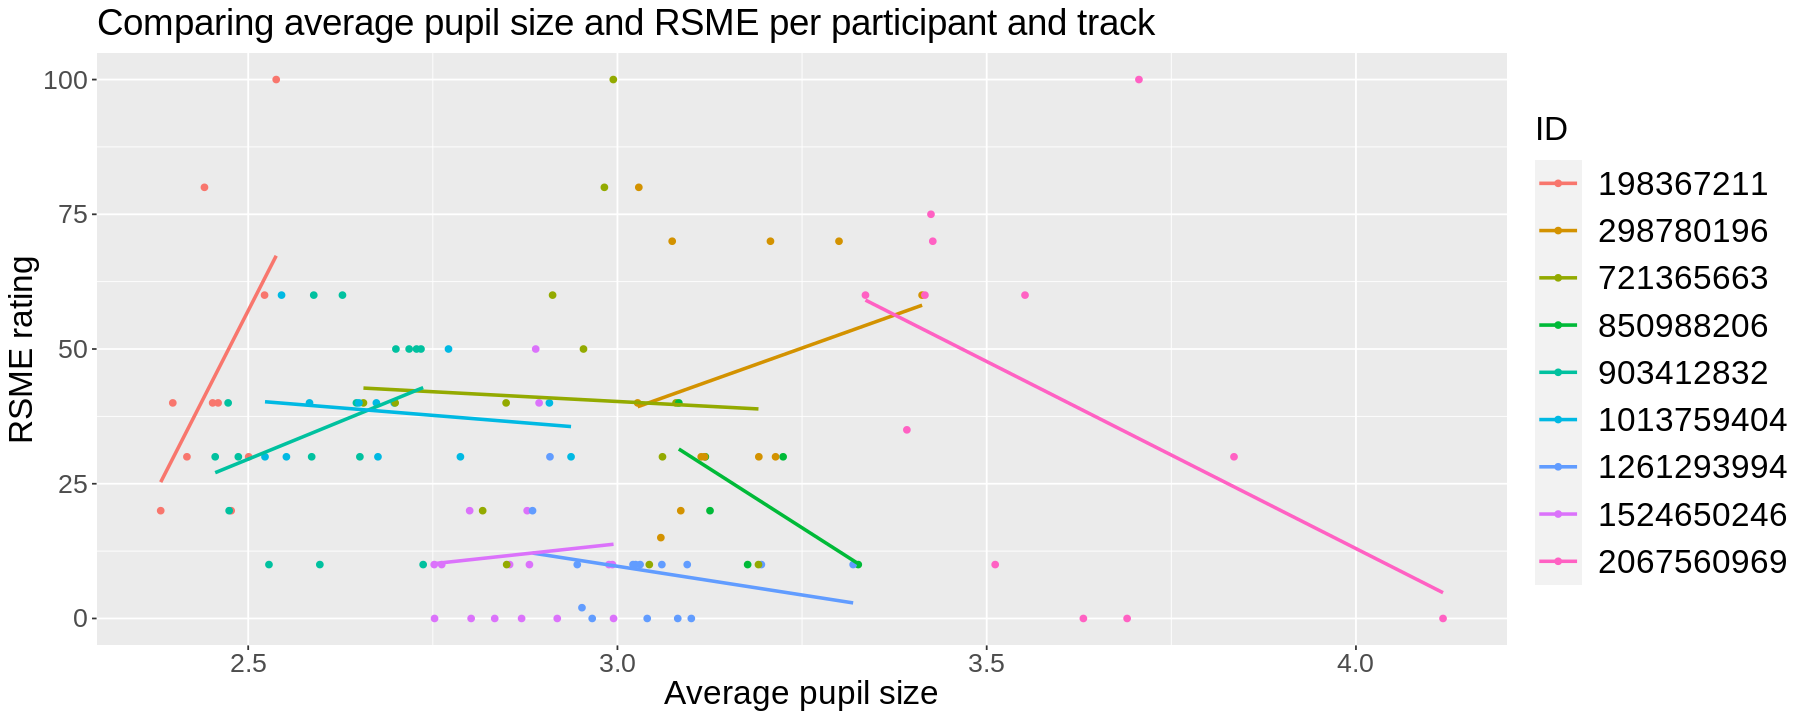

In [133]:
effort <- ggplot(pupilxRSME, aes(x = smooth.pupil, y = RSME, colour = ID)) + geom_point()
effort <- effort + ggtitle("Comparing average pupil size and RSME per participant and track") +
                          xlab("Average pupil size") + ylab("RSME rating") +
                          theme(plot.title = element_text(size = 22),
                                axis.text = element_text(size = 16), axis.title = element_text(size = 20),
                                legend.text = element_text(size = 20), legend.key.size = unit(1, "cm"),
                                legend.title = element_text(size = 20))
effort + geom_smooth(method = lm, se = FALSE)

In [134]:
with(pupilxRSME, cor.test(smooth.pupil, RSME, method = "spearman", exact = F))


	Spearman's rank correlation rho

data:  smooth.pupil and RSME
S = 264746, p-value = 0.1695
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.1307341 


**Conclusions.** From the plot, we see that some participants used more of the RSME scale than others. The correlation is slightly but non-significantly negative, in contrast to our hypothesis. A possible explanation is that participants could not readily apply the concept of mental effort to a task that was generally enjoyable and that they associate with relaxation (i.e., listening to music - see also the results below on emotional response).



### 3.2 How does pupil size relate to liking and familiarity?

Participants reported how much they liked each track and how familiar they were with each track on a scale of 1-7.


*   **Liking:** Looking at the distribution of liking scores, we see that there were many more positive ratings (between 5 - 7) than negative or neutral ratings (< 5), and no ratings of 1. This skewed distribution is not optimal for testing the relationship between pupil size and liking.
*   **Familiarity:** Participants used the entire scale, and tended to be unfamiliar with the music, at least during the first session.

#### 3.2.1 Distributions of liking and familiarity ratings





In [135]:
dist <- aggregate(cbind(liking, track_familiarity) ~ ID + spotify_id + session, allshort, mean)
table(dist$liking)


 2  3  4  5  6  7 
 2 11  7 24 33 35 

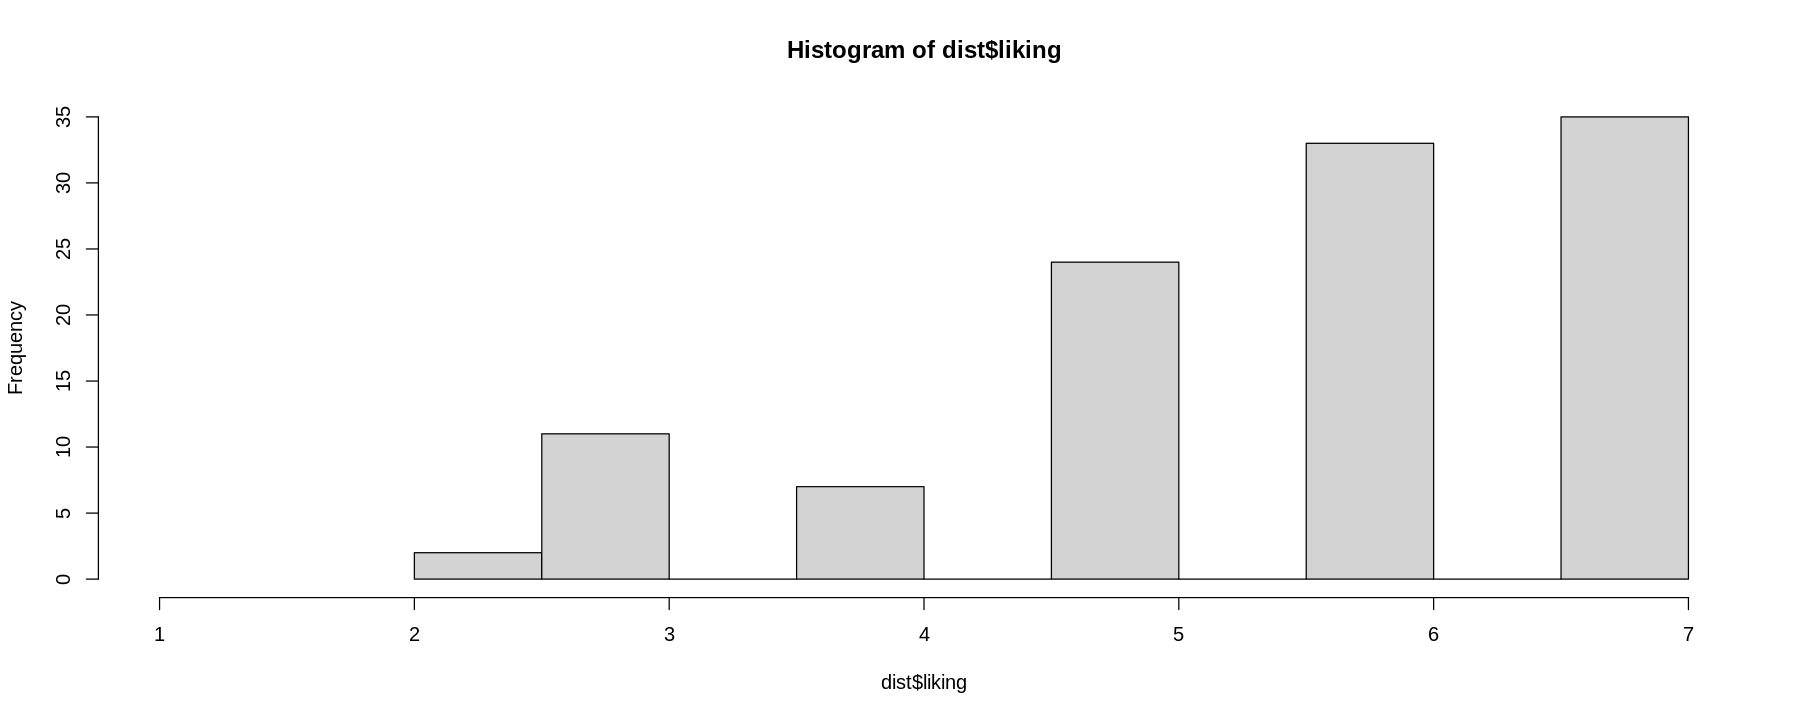

In [136]:
hist(dist$liking, xlim = c(1, 7))

In [137]:
table(dist$track_familiarity)


 1  2  3  4  5  6  7 
33  8  9  8 27 20  7 

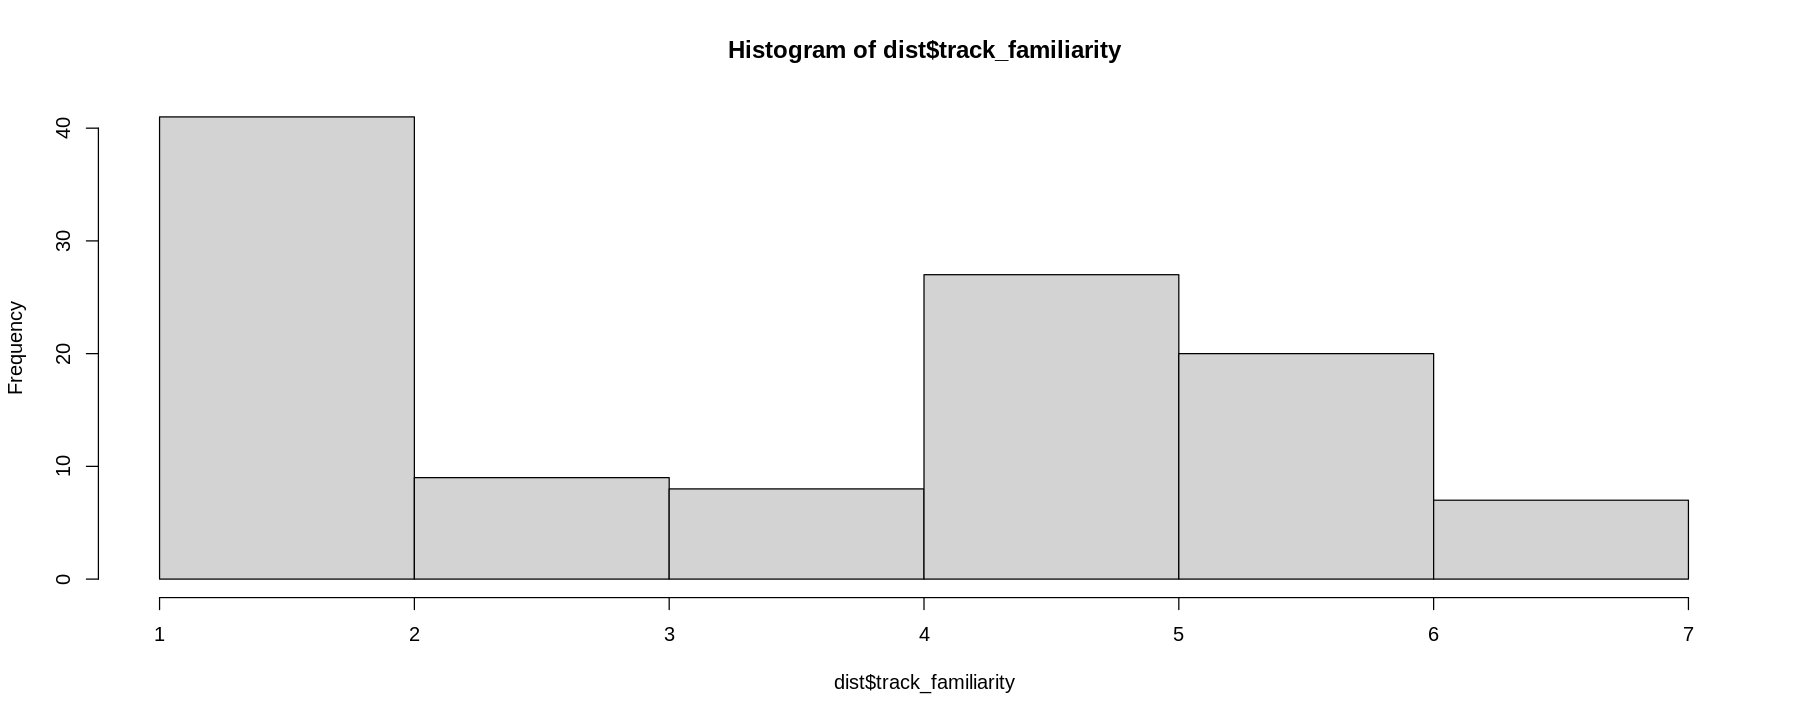

In [138]:
hist(dist$track_familiarity)

### 3.2.2 Pupil response to music with high vs. low liking ratings

When we test for a potential relationship between pupil size and liking or familiarity, we should keep in mind that liking/familiarity ratings are ordinal data, so equal distance between points on the scale cannot be assumed. One way to handle this is to recode ratings into "low" and "high" categories, and test for a difference in pupil size between these groups. Below, this is demonstrated for liking ratings.





In [139]:
allshort$likingcat <- with(allshort, ifelse(liking < 5, "low", "high"))
allshort$likingcat <- as.factor(allshort$likingcat)
allshort$likingcat <- relevel(allshort$likingcat, ref = "low" )

In [140]:
pupilxLikingcat <- aggregate(npupil ~ liking + likingcat + ID + spotify_id + session, allshort, mean)

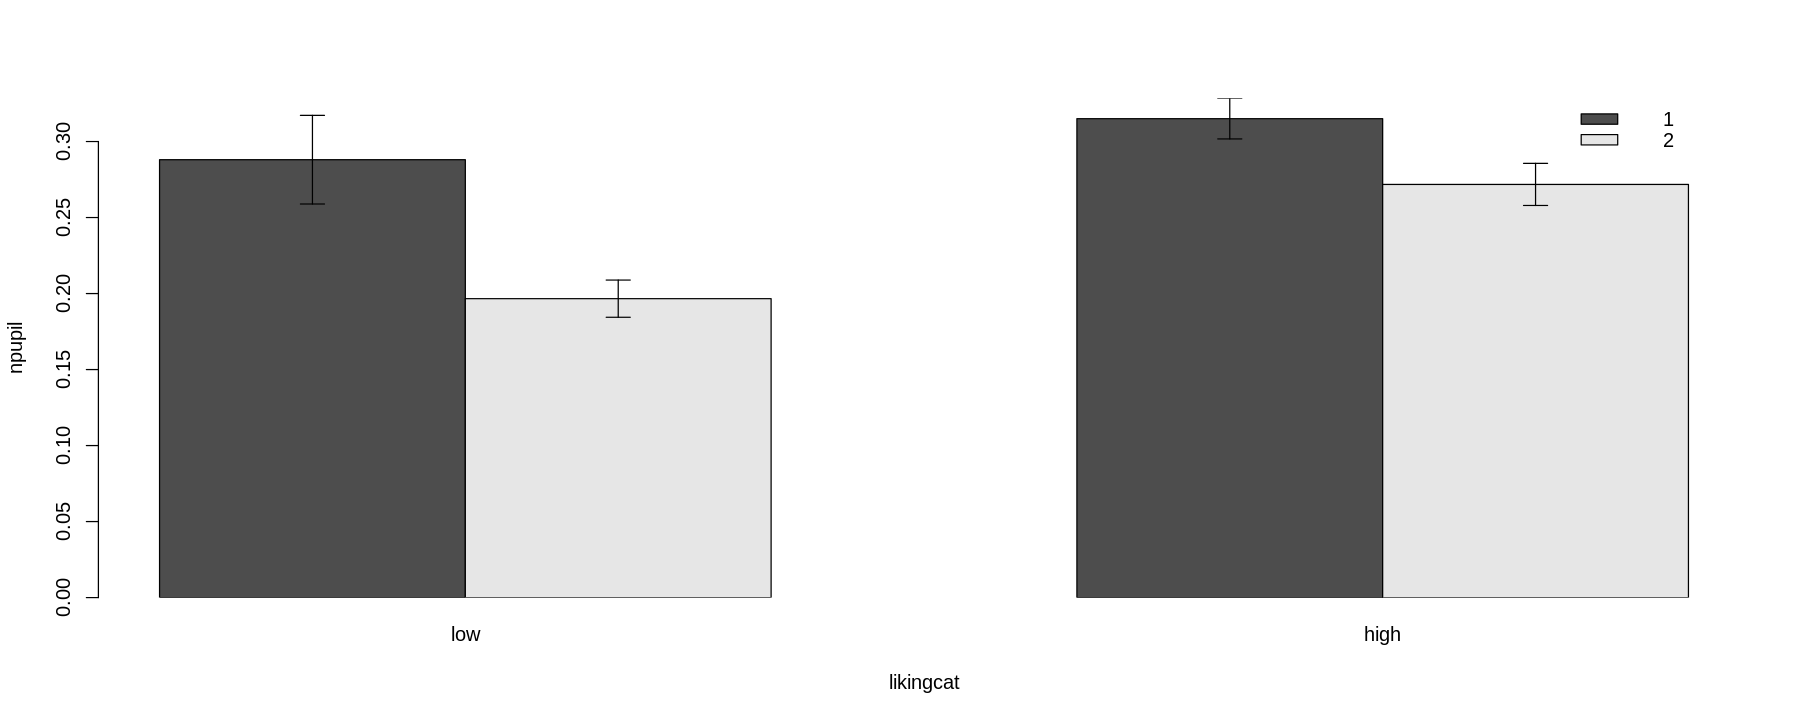

In [147]:
#bargraph.CI(likingcat, npupil, data = pupilxLikingcat)
bargraph.CI(likingcat, npupil, group = session, data = pupilxLikingcat, legend = T,
            x.leg = 5.5)# Test also with session as grouping variable

In [148]:
t.test(pupilxLikingcat[pupilxLikingcat$likingcat == "low", c("npupil")],
pupilxLikingcat[pupilxLikingcat$likingcat == "high", c("npupil")], paired = F)


	Welch Two Sample t-test

data:  pupilxLikingcat[pupilxLikingcat$likingcat == "low", c("npupil")] and pupilxLikingcat[pupilxLikingcat$likingcat == "high", c("npupil")]
t = -1.9019, df = 28.346, p-value = 0.06739
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.089991474  0.003311869
sample estimates:
mean of x mean of y 
0.2514849 0.2948247 


### 3.2.3 Predicting pupil response from liking and familiarity with linear mixed effects models
The relationship between pupil size and liking and/or familiarity ratings can also be tested without recoding the variables. Here, we use linear mixed effects modelling to test whether liking and familiarity predict pupil size. Participant ID is included here as a random effect.

In [149]:
pertrial <- aggregate(smooth.pupil ~ ID + spotify_id + session + liking + track_familiarity, allshort, mean)

In [150]:
# Test for a correlation between liking and track_familiarity
cor.test(pertrial$liking, pertrial$track_familiarity, method = "spearman")

Warning message in cor.test.default(pertrial$liking, pertrial$track_familiarity, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  pertrial$liking and pertrial$track_familiarity
S = 166067, p-value = 0.001873
alternative hypothesis: true rho is not equal to 0
sample estimates:
     rho 
0.290724 


In [164]:
pertrial$session <- factor(pertrial$session)
contrasts(pertrial$session)<- c(-1, 1)

In [165]:
summary(model <- lmer(smooth.pupil ~ liking + track_familiarity + session + (1|ID),
              data = pertrial))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: smooth.pupil ~ liking + track_familiarity + session + (1 | ID)
   Data: pertrial

REML criterion at convergence: -96.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5701 -0.6041 -0.1118  0.5912  3.7927 

Random effects:
 Groups   Name        Variance Std.Dev.
 ID       (Intercept) 0.11384  0.3374  
 Residual             0.01422  0.1193  
Number of obs: 112, groups:  ID, 9

Fixed effects:
                    Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)         2.829723   0.127106  12.638552  22.263 1.62e-11 ***
liking              0.023651   0.009734 100.494229   2.430   0.0169 *  
track_familiarity  -0.005837   0.010307 101.688324  -0.566   0.5724    
session1           -0.036196   0.018897 101.212384  -1.915   0.0583 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) liking trck_f
likin

In [166]:
vif(model)

liking track_familiarity           session 
         1.080854          2.748064          2.620913

In [167]:
summary(model <- lmer(smooth.pupil ~ liking*session + track_familiarity*session + (1|ID),
              data = pertrial))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: smooth.pupil ~ liking * session + track_familiarity * session +  
    (1 | ID)
   Data: pertrial

REML criterion at convergence: -84.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5715 -0.5872 -0.1324  0.5388  3.9488 

Random effects:
 Groups   Name        Variance Std.Dev.
 ID       (Intercept) 0.1132   0.3365  
 Residual             0.0142   0.1191  
Number of obs: 112, groups:  ID, 9

Fixed effects:
                             Estimate Std. Error         df t value Pr(>|t|)
(Intercept)                 2.7968745  0.1291146 13.5581231  21.662 6.53e-12
liking                      0.0224555  0.0101520 98.4374220   2.212   0.0293
session1                   -0.1088416  0.0575763 98.0902612  -1.890   0.0617
track_familiarity          -0.0001771  0.0119494 99.1585182  -0.015   0.9882
liking:session1             0.0029190  0.0096025 98.1980690   0.304   0.7618
session1:track_fam

**Conclusions.** When we include liking, familiarity, and session as separate fixed effects in the model, there is a significant positive effect of liking on pupil size. The effect is maintained when we include the interactions between liking x session and familiarity x session.

### 3.3 Does pupil size predict listeners' emotional response?
Most eye-tracking software has a function for Area of Interest (AOI) analysis. Typically, the experimenter draws AOIs on the visual display that participants viewed during the experiment. The software function then run, and outputs "hits" for each sample (or fixation) where gaze position was recorded in any of the defined AOIs.

In our experiment, participants viewed the Circumplex model while listening to each track. They were instructed to look at the term(s) that best represented their emotional response to the music. They could look at different terms, one after another, if their emotional state changed as they listened. This allowed us to get a real-time measure of their subjective emotional experience during the listening task.

#### 3.3.1 Percentage of experiment time spent looking at emotion terms
An important question to address before analysing these data is how much time participants actually spend looking at one or another of the AOIs. We test this below by summing up the total number of data samples in which an AOI hit was recorded, and taking this sum as a percentage of the total number of data samples:

In [168]:
aoi.data <- read.table("MusicDiscoveryPupil/ET-partial2.txt")

In [169]:
AOI.only <- aoi.data[, grepl("AOI", colnames(aoi.data))]
AOI.only$sum.of.hits <- rowSums(AOI.only)
AOI.only[1000:1006,]

,AOI.hit..Activation.,AOI.hit..Pleasant.,AOI.hit..Deactivation.,AOI.hit..Unpleasant.,AOI.hit..Alert.,AOI.hit..Excited.,AOI.hit..Elated.,AOI.hit..Happy.,AOI.hit..Contented.,AOI.hit..Serene.,⋯,AOI.hit..Calm.,AOI.hit..Fatigued.,AOI.hit..Lethargic.,AOI.hit..Depressed.,AOI.hit..Sad.,AOI.hit..Upset.,AOI.hit..Stressed.,AOI.hit..Nervous.,AOI.hit..Tense.,sum.of.hits
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
7824,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,1,1
7825,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,1,1
7826,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,1,1
7827,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,1,1
7828,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,1,1
7829,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,1,1
7830,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,1,1


In [170]:
mean(AOI.only$sum.of.hits, na.rm = T)*100

[1] 53.3385

Across all participants and trials, only about 53% of listening time was spent with gaze fixed on one or another of the emotion terms. This is perhaps unsurprising, as participants might have needed some time to listen to the music and reflect before selecting an emotion. In the plot below, we show the position of all gaze data collected during the experiment relative to the Circumplex model. Non-AOI data is in dark blue, and AOI hits are in in light blue.

In [171]:
aoi.data$hit <- rowSums(aoi.data[, grepl("AOI", colnames(aoi.data))])
hits <- aoi.data[aoi.data$hit == 1, ]

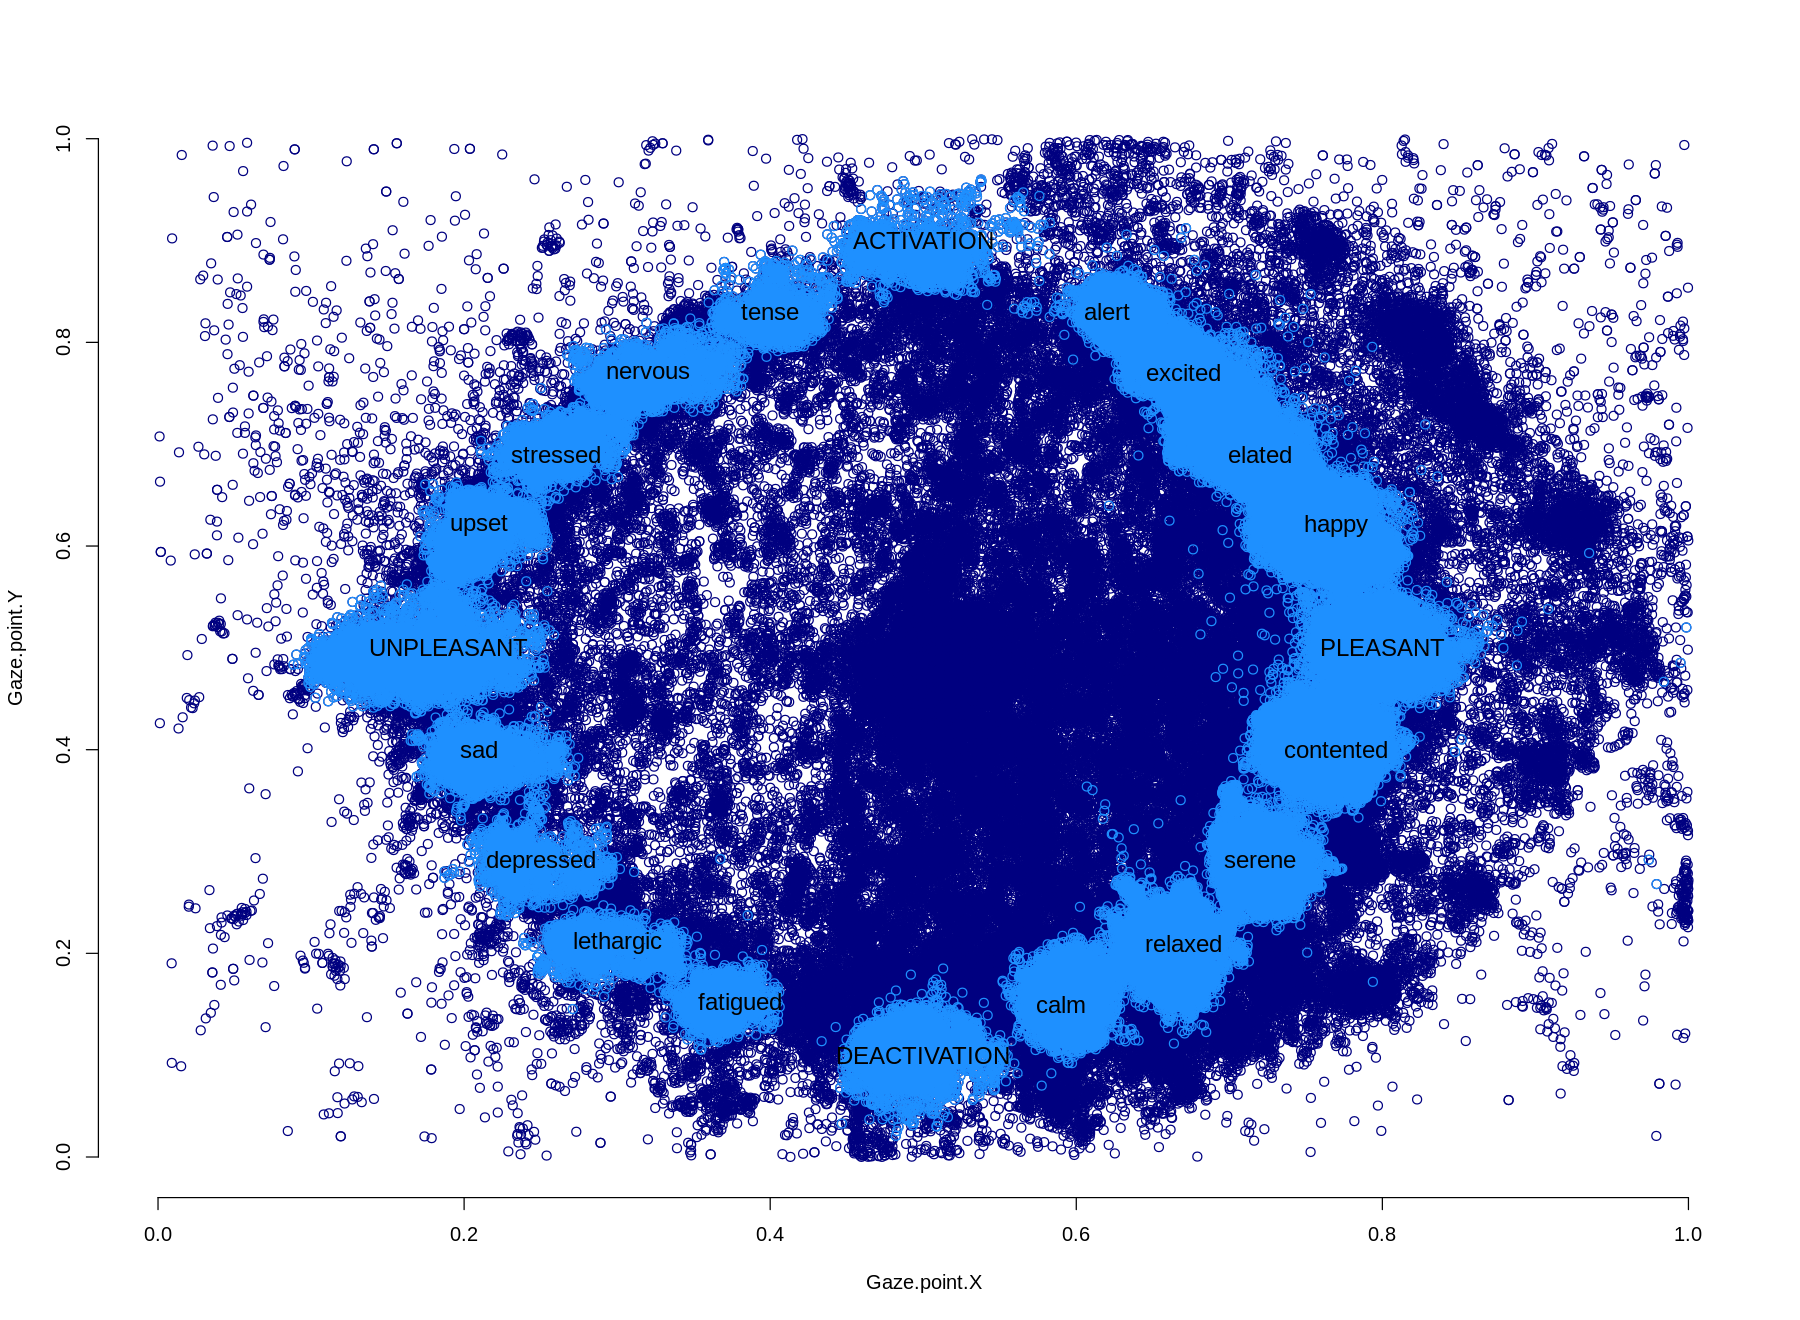

In [172]:
options(repr.plot.width = 15, repr.plot.height = 11)
with(aoi.data,
     plot(Gaze.point.X, Gaze.point.Y, col = "navy", bty = "n"))
with(hits,
     points(Gaze.point.X, Gaze.point.Y, col = "dodgerblue"))
text(c(.5, .5, .8, .19), c(.9, .1, .5, .5),
     label = c("ACTIVATION", "DEACTIVATION", "PLEASANT", "UNPLEASANT"),
     cex = 1.2)
text(c(.62, .67, .72, .77, .77, .72, .67, .59, .38, .30, .25, .21, .21, .26, .32, .4),
     c(.83, .77, .69, .62, .40, .29, .21, .15, .15, .21, .29, .40, .62, .69, .77, .83),
     label = c("alert", "excited", "elated", "happy", "contented", "serene", "relaxed", "calm",
               "fatigued", "lethargic", "depressed", "sad", "upset", "stressed", "nervous", "tense"),
     cex = 1.2)

When participants were not looking at one or another of the emotion terms, where were they looking instead? The answer seems to be everywhere: their gaze was mostly inside the circle, where they were probably looking while they decided on their response. We can see from the plot that participants spent overall more time looking at the right side of the circle (pleasant emotions).

#### 3.3.2 Which emotions did participants experience while listening?
Below, we calculate how "hits" were distributed across the different emotion terms on the Circumplex model. The plot below represents the distribution of emotional responses that arose across the participant sample during the experiment.

In [173]:
AOI.only.nosum <- AOI.only[!is.na(AOI.only$AOI.hit..Pleasant.),!grepl("sum", colnames(AOI.only))]
sum.per.emotion <- colSums(AOI.only.nosum, na.rm = T)
number.of.hits <- nrow(AOI.only[which(AOI.only$sum.of.hits == 1), ])

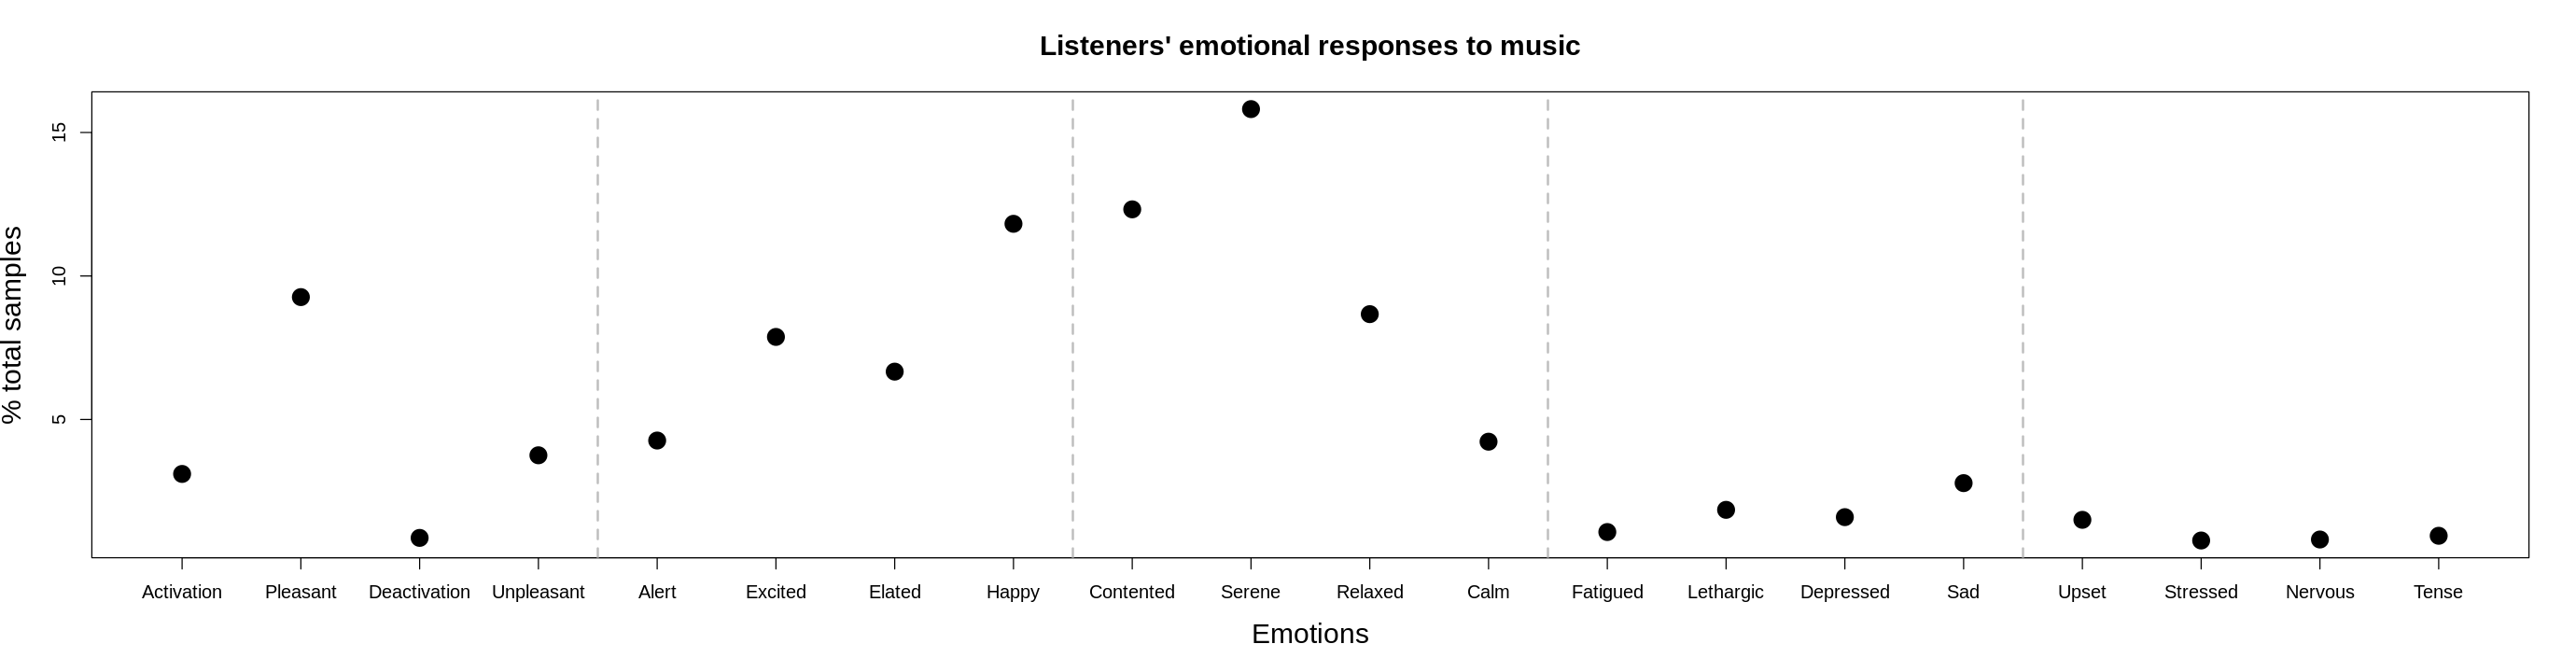

In [174]:
options(repr.plot.width = 23, repr.plot.height = 6)

plot(sum.per.emotion/number.of.hits * 100, xaxt = "n",
      pch = 19, cex = 2,
      xlab = "Emotions", ylab = "% total samples", cex.lab = 1.5,
      main = "Listeners' emotional responses to music", cex.main = 1.5)
axis(1, at = 1:20, labels = mgsub(colnames(AOI.only.nosum), c("AOI.hit", "\\."), c("", "")))
abline(v = c(4.5, 8.5, 12.5, 16.5), lty = 2, col = "grey", lwd = 2)

Next, we calculate what percentage of

In [175]:
aoi.data$quadActPleas <- rowSums(aoi.data[,c(9, 10, 13:16)])
aoi.data$quadDeactPleas <- rowSums(aoi.data[,c(10, 11, 17:20)])
aoi.data$quadDeactUnpleas <- rowSums(aoi.data[,c(11, 12, 21:24)])
aoi.data$quadActUnpleas <- rowSums(aoi.data[,c(9, 12, 25:28)])

In [176]:
quad.df <- data.frame(ID = aoi.data$ID,
                      spotify_id = aoi.data$spotify_id,
                      session = aoi.data$session,
                      smooth.pupil = aoi.data$smooth.pupil,
                      npupil = aoi.data$npupil,
                      quadsums = c(aoi.data$quadActPleas, aoi.data$quadDeactPleas,
                                  aoi.data$quadDeactUnpleas, aoi.data$quadActUnpleas),
                      quadlabel = c(rep("ActPleas", nrow(aoi.data)), rep("DeactPleas", nrow(aoi.data)),
                                    rep("DeactUnpleas", nrow(aoi.data)), rep("ActUnpleas", nrow(aoi.data))))
quad.hit <- quad.df[quad.df$quadsums == 1, ]

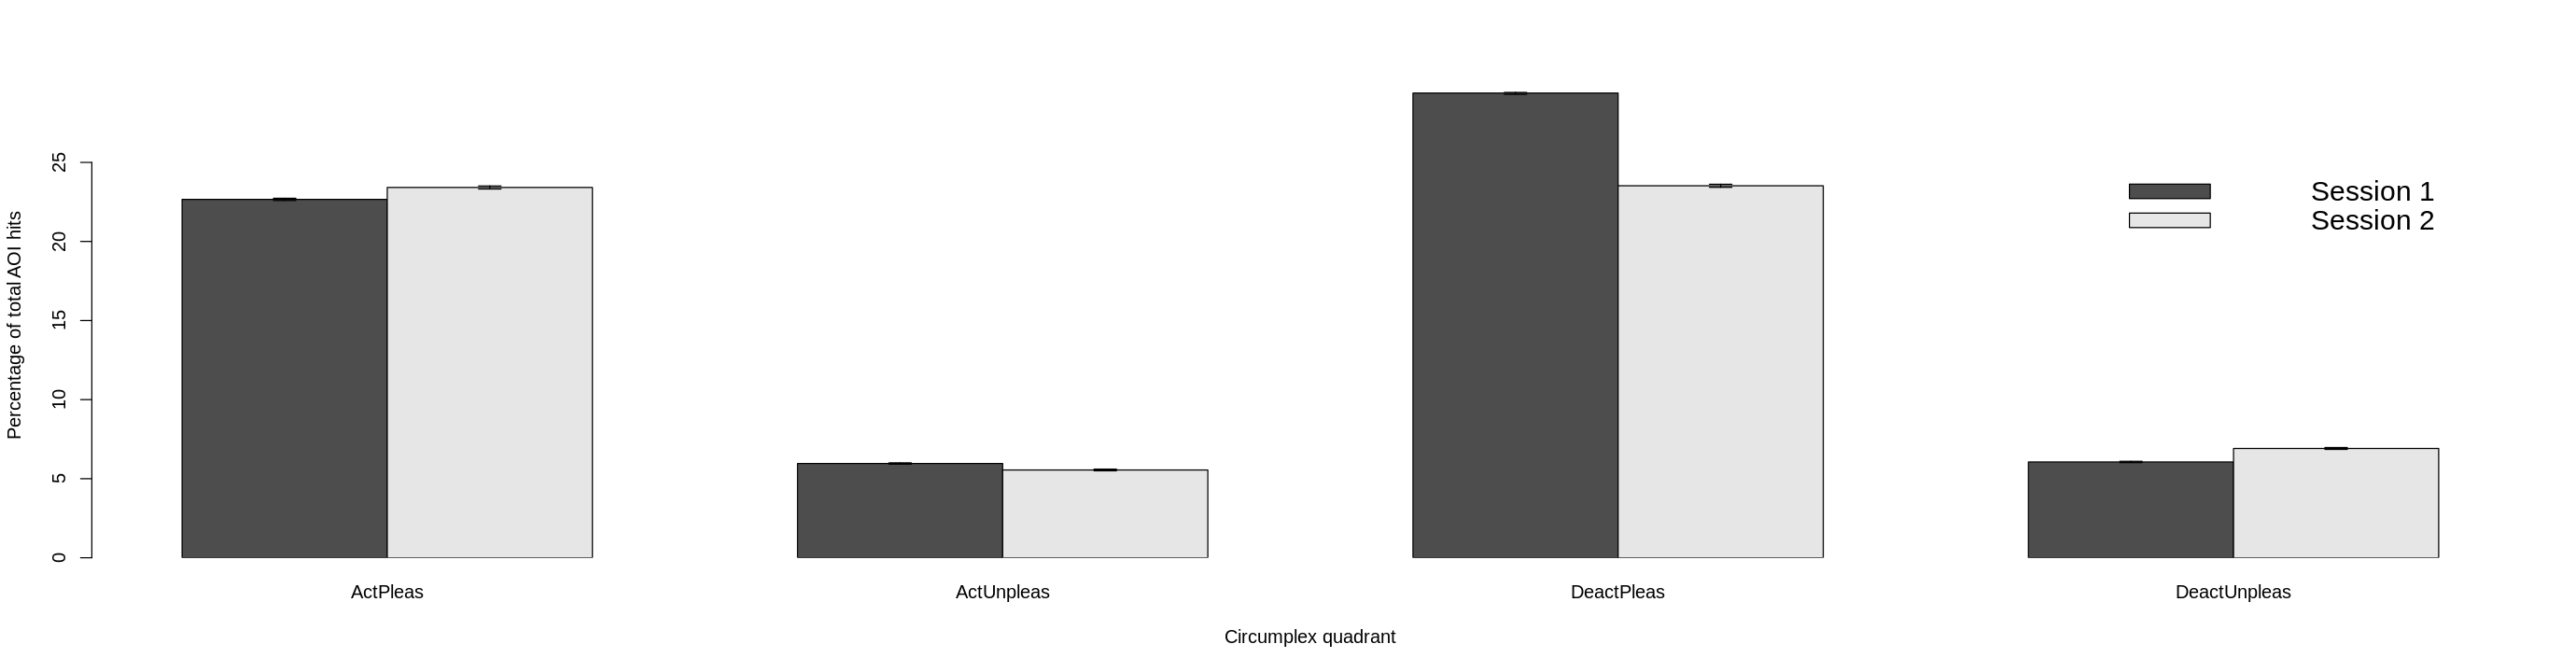

In [184]:
bargraph.CI(quadlabel, quadsums*100, group = session, data = quad.df, legend = TRUE,
            xlab = "Circumplex quadrant", ylab = "Percentage of total AOI hits",
            x.leg = 10, y.leg = 25, cex.leg = 1.5, leg.lab = c("Session 1", "Session 2"))

In [185]:
pupilxQuad <- aggregate(npupil ~ quadlabel + ID + spotify_id + session, quad.hit, mean,
                        na.action = na.pass, na.rm = T)

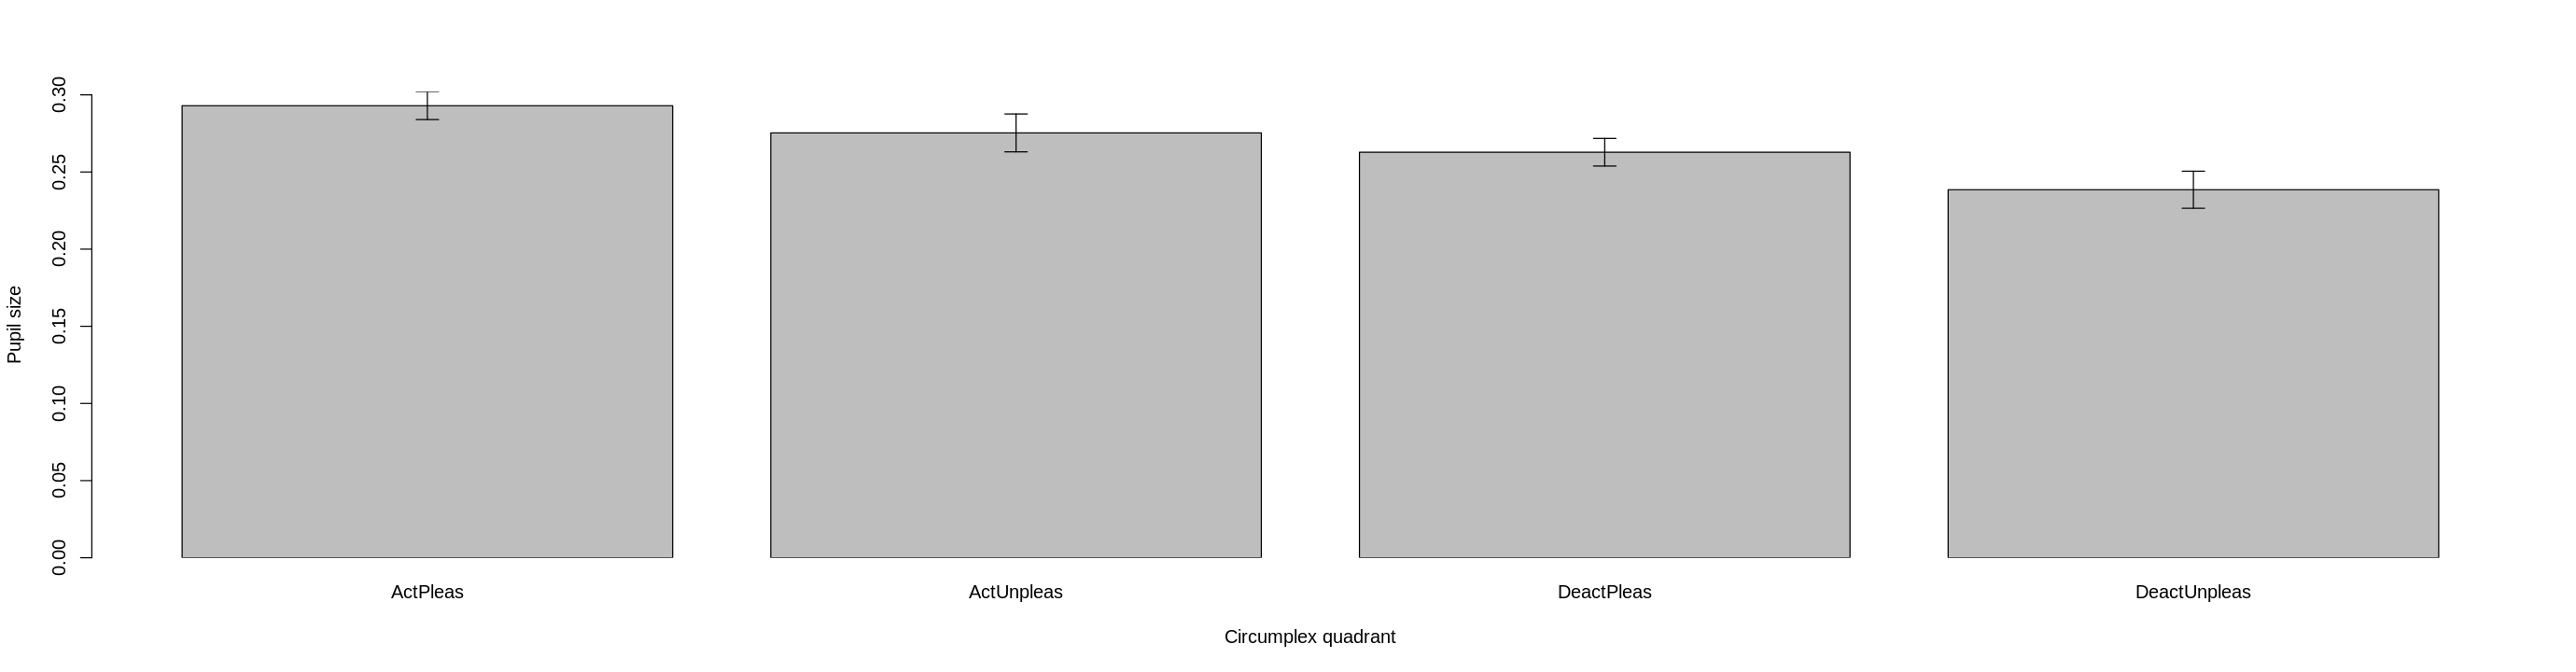

In [186]:
bargraph.CI(quadlabel, npupil, data = pupilxQuad,
            xlab = "Circumplex quadrant", ylab = "Pupil size")

In [187]:
pupilxQuad$Activation <- with(pupilxQuad, ifelse(grepl("Act", quadlabel), "Act", "Deact"))

In [190]:
t.test(pupilxQuad[pupilxQuad$quadlabel == "ActPleas", c("npupil")],
       pupilxQuad[pupilxQuad$quadlabel == "ActUnpleas", c("npupil")])


	Welch Two Sample t-test

data:  pupilxQuad[pupilxQuad$quadlabel == "ActPleas", c("npupil")] and pupilxQuad[pupilxQuad$quadlabel == "ActUnpleas", c("npupil")]
t = 1.1575, df = 196.05, p-value = 0.2485
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.01240426  0.04765107
sample estimates:
mean of x mean of y 
0.2929536 0.2753302 


In [192]:
t.test(pupilxQuad[pupilxQuad$quadlabel == "ActPleas", c("npupil")],
       pupilxQuad[pupilxQuad$quadlabel == "DeactPleas", c("npupil")])


	Welch Two Sample t-test

data:  pupilxQuad[pupilxQuad$quadlabel == "ActPleas", c("npupil")] and pupilxQuad[pupilxQuad$quadlabel == "DeactPleas", c("npupil")]
t = 2.3768, df = 248, p-value = 0.01822
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.005165214 0.055131993
sample estimates:
mean of x mean of y 
0.2929536 0.2628050 


In [193]:
t.test(pupilxQuad[pupilxQuad$quadlabel == "ActPleas", c("npupil")],
       pupilxQuad[pupilxQuad$quadlabel == "DeactUnpleas", c("npupil")])


	Welch Two Sample t-test

data:  pupilxQuad[pupilxQuad$quadlabel == "ActPleas", c("npupil")] and pupilxQuad[pupilxQuad$quadlabel == "DeactUnpleas", c("npupil")]
t = 3.6281, df = 195.74, p-value = 0.0003643
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.02484630 0.08402855
sample estimates:
mean of x mean of y 
0.2929536 0.2385162 


**Conclusions.** Participants' emotional response to the music they heard was mostly positive: most AOI hits were in the pleasant-deactivation quadrant, followed by the pleasant-activation quadrant. Notably, hits were more evenly distributed between the two quadrants in the second listening session. Pupil size was largest when participants experienced pleasant activation, and smallest when participants experienced unpleasant deactivation. The effect of activation is in line with the idea that pupil dilation occurs during cognitive arousal. The added effect of pleasant emotions suggest that participants might have been more engaged by music that elicited a pleasant emotional response.